# Modelo de Clasificación para personajes de Los Simpson

## Librerías

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import fasttext
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import pickle
import joblib

## Cargar Datos

In [2]:
df = pd.read_csv('The Saimpsons Archive/in_use/simpsons_script_lines.csv')
df.shape

(158270, 13)

In [3]:
df.sample()

,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
75070,85005,294,155,(Highway: ext. highway - continuous),738000,False,NaN,238.0,NaN,Highway,NaN,NaN,0.0


In [4]:
df = df[df['speaking_line']==True]
df.shape

(132112, 13)

In [5]:
df = df[['episode_id', 'character_id', 'raw_character_text', 'location_id', 'spoken_words']]
df.shape

(132112, 5)

# Filtrado por relevancia de personajes

In [6]:
df.sample()

,episode_id,character_id,raw_character_text,location_id,spoken_words
150153,5,104.0,Weasel #2,73.0,Too bad.


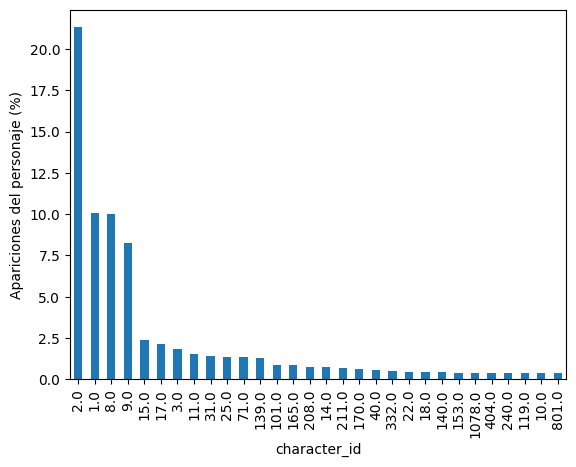

In [7]:
char_relevance = df['character_id'].value_counts(normalize=True) *100

char_relevance.sort_values(ascending=False).head(30).plot(kind='bar')
plt.ylabel('Apariciones del personaje (%)')
plt.xlabel('character_id')
plt.show()

In [8]:
def count_words(text):
    return len(text.split())

df['spoken_words_count'] = df['spoken_words'].apply(lambda x: count_words(x))
df

,episode_id,character_id,raw_character_text,location_id,spoken_words,spoken_words_count
0,32,464.0,Miss Hoover,3.0,"No, actually, it was a little of both. Sometim...",31
1,32,9.0,Lisa Simpson,3.0,Where's Mr. Bergstrom?,3
2,32,464.0,Miss Hoover,3.0,I don't know. Although I'd sure like to talk t...,22
3,32,9.0,Lisa Simpson,3.0,That life is worth living.,5
4,32,40.0,Edna Krabappel-Flanders,3.0,The polls will be open from now until the end ...,33
...,...,...,...,...,...,...
158265,32,464.0,Miss Hoover,3.0,I'm back.,2
158266,32,464.0,Miss Hoover,3.0,"You see, class, my Lyme disease turned out to ...",10
158267,32,464.0,Miss Hoover,3.0,Psy-cho-so-ma-tic.,1
158268,32,119.0,Ralph Wiggum,3.0,Does that mean you were crazy?,6


In [9]:
df = df.query('spoken_words_count >= 5')
df.shape

(96900, 6)

In [10]:
df=df.reset_index()
df

,index,episode_id,character_id,raw_character_text,location_id,spoken_words,spoken_words_count
0,0,32,464.0,Miss Hoover,3.0,"No, actually, it was a little of both. Sometim...",31
1,2,32,464.0,Miss Hoover,3.0,I don't know. Although I'd sure like to talk t...,22
2,3,32,9.0,Lisa Simpson,3.0,That life is worth living.,5
3,4,32,40.0,Edna Krabappel-Flanders,3.0,The polls will be open from now until the end ...,33
4,5,32,38.0,Martin Prince,3.0,I don't think there's anything left to say.,8
...,...,...,...,...,...,...,...
96895,158261,32,9.0,Lisa Simpson,373.0,Can we do it this week?,6
96896,158263,32,9.0,Lisa Simpson,3.0,"Mr. Bergstrom, we request the pleasure of your...",33
96897,158266,32,464.0,Miss Hoover,3.0,"You see, class, my Lyme disease turned out to ...",10
96898,158268,32,119.0,Ralph Wiggum,3.0,Does that mean you were crazy?,6


In [11]:
mas_de_1000 = df['character_id'].value_counts()[df['character_id'].value_counts() > 1000].index
df = df[df['character_id'].isin(mas_de_1000)]
df

,index,episode_id,character_id,raw_character_text,location_id,spoken_words,spoken_words_count
2,3,32,9.0,Lisa Simpson,3.0,That life is worth living.,5
5,7,32,8.0,Bart Simpson,3.0,Victory party under the slide!,5
7,11,32,9.0,Lisa Simpson,374.0,Do you know where I could find him?,8
9,13,32,9.0,Lisa Simpson,374.0,"The train, how like him... traditional, yet en...",9
11,15,32,9.0,Lisa Simpson,374.0,"I see he touched you, too.",6
...,...,...,...,...,...,...,...
96892,158251,32,9.0,Lisa Simpson,373.0,Can I dye my shoes pink?,6
96893,158253,32,9.0,Lisa Simpson,373.0,Can I paint my nails?,5
96894,158259,32,9.0,Lisa Simpson,373.0,Does Bart have to be there?,6
96895,158261,32,9.0,Lisa Simpson,373.0,Can we do it this week?,6


In [12]:
df.isna().sum()

index                   0
episode_id              0
character_id            0
raw_character_text      0
location_id           113
spoken_words            0
spoken_words_count      0
dtype: int64

In [13]:
df.dropna(subset=['raw_character_text'], inplace=True)

In [14]:
df = df.reset_index()
df = df.drop(['index', 'level_0'], axis=1)
df.sample()

,episode_id,character_id,raw_character_text,location_id,spoken_words,spoken_words_count
8423,113,25.0,Milhouse Van Houten,1149.0,What's goin' on? Where are the grown-ups?,7


In [15]:
len(df['character_id'].unique()), df['raw_character_text'].unique()

(12,
 array(['Lisa Simpson', 'Bart Simpson', 'Milhouse Van Houten',
        'Homer Simpson', 'Marge Simpson', 'Ned Flanders', 'Grampa Simpson',
        'C. Montgomery Burns', 'Moe Szyslak', 'Krusty the Clown',
        'Chief Wiggum', 'Seymour Skinner', "Bart's Thoughts",
        "Lisa's Thoughts", 'Young Marge', "Marge's Thoughts",
        'Teenage Lisa', 'Teenage Milhouse', 'Young Burns', 'Teenage Marge',
        'Young Grampa', 'Adult Lisa', 'Young Homer', 'Teenage Homer',
        'Young Krusty', 'Teenage Bart', 'Adult Bart', 'Adult "Bart"',
        "Homer's Brain", "Homer's Thoughts", 'Kirk Voice Milhouse'],
       dtype=object))

In [16]:
def what_char(text):
    words = text.lower()
    words = words.split()

    if 'homer' in words:
        return 'Homer Simpson'
    elif 'marge' in words:
        return 'Marge Simpson'
    elif 'bart' in words:
        return 'Bart Simpson'
    elif 'lisa' in words:
        return 'Lisa Simpson'
    # elif 'burns' in words:
    #     return 'C. Montgomery Burns'
    # elif 'milhouse' in words:
    #     return 'Milhouse Van Houten'
    # elif 'ned' in words:
    #     return 'Ned Flanders'
    # elif 'grampa' in words:
    #     return 'Grampa Simpson'
    # elif 'krusty' in words:
    #     return 'Krusty The Clown'
    # elif 'moe' in words:
    #     return 'Moe Szyslak'
    # elif 'wiggum' in words:
    #     return 'Chief Wiggum'
    # elif 'seymour' in words:
    #     return 'Seymour Skinner'
    else:
        return 'Others'

In [17]:
df['text_char_simplified'] = df['raw_character_text'].apply(lambda x: what_char(x))
df

,episode_id,character_id,raw_character_text,location_id,spoken_words,spoken_words_count,text_char_simplified
0,32,9.0,Lisa Simpson,3.0,That life is worth living.,5,Lisa Simpson
1,32,8.0,Bart Simpson,3.0,Victory party under the slide!,5,Bart Simpson
2,32,9.0,Lisa Simpson,374.0,Do you know where I could find him?,8,Lisa Simpson
3,32,9.0,Lisa Simpson,374.0,"The train, how like him... traditional, yet en...",9,Lisa Simpson
4,32,9.0,Lisa Simpson,374.0,"I see he touched you, too.",6,Lisa Simpson
...,...,...,...,...,...,...,...
60283,32,9.0,Lisa Simpson,373.0,Can I dye my shoes pink?,6,Lisa Simpson
60284,32,9.0,Lisa Simpson,373.0,Can I paint my nails?,5,Lisa Simpson
60285,32,9.0,Lisa Simpson,373.0,Does Bart have to be there?,6,Lisa Simpson
60286,32,9.0,Lisa Simpson,373.0,Can we do it this week?,6,Lisa Simpson


In [18]:
print(df['text_char_simplified'].value_counts(),'\n\n',df['character_id'].value_counts())

text_char_simplified
Homer Simpson    19950
Others           13885
Marge Simpson     9864
Bart Simpson      8913
Lisa Simpson      7676
Name: count, dtype: int64 

 character_id
2.0      20060
1.0       9884
8.0       8931
9.0       7717
15.0      2446
17.0      2260
3.0       1908
11.0      1613
71.0      1450
31.0      1400
139.0     1384
25.0      1235
Name: count, dtype: int64


# Word Embedding

In [19]:
text_column = df['spoken_words']
#text_column.to_csv('The Saimpsons Archive/in_use/text_data_train_fasttext_spoken_words.txt', index=False, header=False, sep='\n')

# Entrenando al fasttext embedding_model a usar
embedding_model = fasttext.train_supervised(input="The Saimpsons Archive/in_use/text_data_train_fasttext.txt", lr=0.1, epoch=25, wordNgrams=2)

# Function to obtain FastText embeddings for a single text
def get_fasttext_embedding(text):
    text = text.replace('\n', '')
    return embedding_model.get_sentence_vector(text)

# Apply the function to each text in the DataFrame column
embeddings = text_column.apply(get_fasttext_embedding)

# Convert embeddings to DataFrame
embedding_df = pd.DataFrame(embeddings.tolist(), columns=[f'embedding_{i}' for i in range(embeddings.iloc[0].shape[0])])

# Concatenate the embedding DataFrame with the original DataFrame
result_df = pd.concat([df[['character_id', 'raw_character_text', 'text_char_simplified', 'location_id']], embedding_df], axis=1)

Read 1M words
Number of words:  137245
Number of labels: 0
Progress: 100.0% words/sec/thread: 12564130 lr:  0.000000 avg.loss:       nan ETA:   0h 0m 0s


In [20]:
result_df.sample()

,character_id,raw_character_text,text_char_simplified,location_id,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,...,embedding_90,embedding_91,embedding_92,embedding_93,embedding_94,embedding_95,embedding_96,embedding_97,embedding_98,embedding_99
37037,2.0,Homer Simpson,Homer Simpson,5.0,-0.001581,-0.000102,0.00039,-0.00083,-0.000114,0.001336,...,0.000595,0.000997,-0.000275,-0.001945,0.000755,-0.000015,-0.003137,0.001068,-0.001635,-0.000258


In [21]:
df.shape, embedding_df.shape, result_df.shape

((60288, 7), (60288, 100), (60288, 104))

In [22]:
result_df.isna().sum()

character_id              0
raw_character_text        0
text_char_simplified      0
location_id             113
embedding_0               0
                       ... 
embedding_95              0
embedding_96              0
embedding_97              0
embedding_98              0
embedding_99              0
Length: 104, dtype: int64

In [23]:
result_df['location_id'] = result_df['location_id'].fillna(0)

In [24]:
result_df.isna().sum()

character_id            0
raw_character_text      0
text_char_simplified    0
location_id             0
embedding_0             0
                       ..
embedding_95            0
embedding_96            0
embedding_97            0
embedding_98            0
embedding_99            0
Length: 104, dtype: int64

In [25]:
# nan_df = result_df.isnull()

# # Plot the heatmap
# plt.figure(figsize=(8, 6))
# sns.heatmap(nan_df, cmap='viridis', cbar=False)
# plt.title('NaN Heatmap')
# plt.show()

# Probando qué modelos de clasificación actúan mejor:

In [26]:
# Dividir el DataFrame en características (X) y etiquetas (y)
X = result_df.drop(['character_id', 'raw_character_text', 'text_char_simplified'], axis=1) 
y = result_df['text_char_simplified']

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1989, stratify=y)

# Escalar características para normalizarlas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear y entrenar el modelo de regresión logística
model = RandomForestClassifier(class_weight='balanced')
model.fit(X_train_scaled, y_train)

# Predecir las etiquetas para el conjunto de prueba
y_pred = model.predict(X_test_scaled)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Mostrar el reporte de clasificación
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.34864820036490296

Classification Report:
               precision    recall  f1-score   support

 Bart Simpson       0.22      0.01      0.02      1783
Homer Simpson       0.35      0.85      0.49      3990
 Lisa Simpson       0.38      0.01      0.01      1535
Marge Simpson       0.40      0.03      0.06      1973
       Others       0.36      0.26      0.30      2777

     accuracy                           0.35     12058
    macro avg       0.34      0.23      0.18     12058
 weighted avg       0.34      0.35      0.25     12058



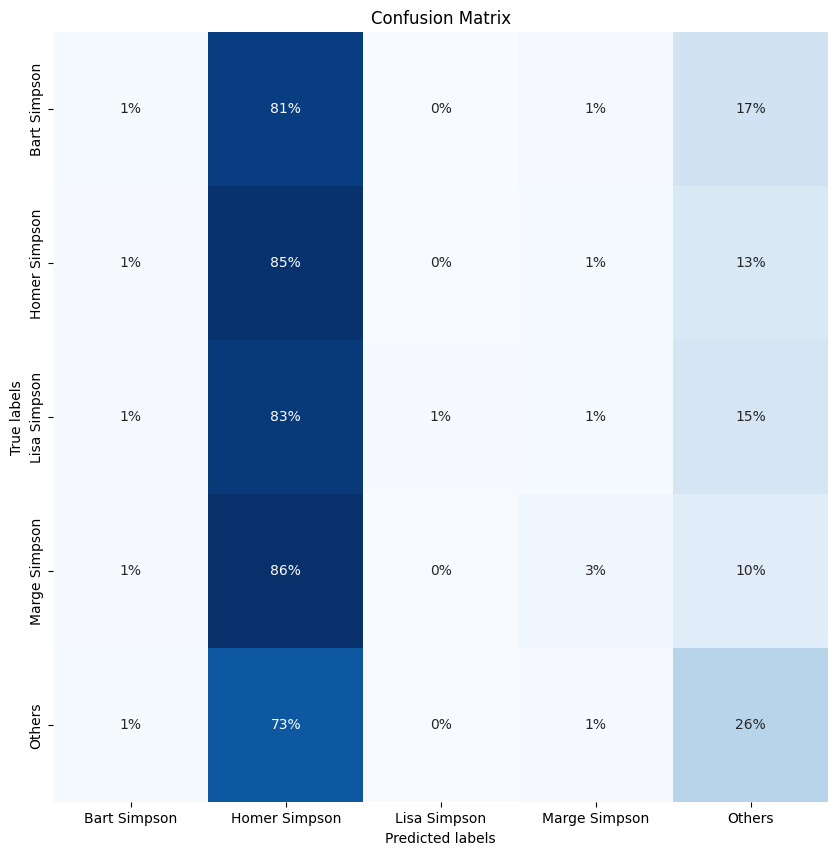

In [27]:
class_labels = np.unique(y_test)
conf_matrix=confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(10,10))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='.0%', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Intento red neuronal a ver si funciona mejor

In [28]:
def scheduler(epoch, lr):
    return lr * np.exp(-0.1)

lr_schedule = LearningRateScheduler(scheduler)

In [29]:
# Dividir el DataFrame en características (X) y etiquetas (y)
X = result_df.drop(['character_id', 'raw_character_text', 'text_char_simplified'], axis=1) 
y = result_df['text_char_simplified']  
label = LabelEncoder()
y_enc = label.fit_transform(y)

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, random_state=1989, stratify=y_enc)

# Escalar características para normalizarlas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [30]:
# random_state = 1989
tf.random.set_seed(1989)
np.random.seed(1989)

#red neuronal:
f_int = X_train_scaled.shape[1]

modelo = Sequential()

# Capa entrada
modelo.add(Dense(1024, activation='relu', input_dim=f_int))
# Capas intermedias (si hay):
# modelo.add(Dense(128, activation='tanh'))
#model_tam.add(Dropout(rate=0.3))
#Capa salida
nodos_salida = int(len(np.unique(y)))
modelo.add(Dense(nodos_salida, activation="softmax")) #como es clasificación multiclase la salida tiene que ser con softmax.

#Aprendizaje ratio
adam = Adam(learning_rate=.05)

#Compilación
modelo.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

# model_tam.summary()

In [31]:
history = modelo.fit(
    X_train_scaled,
    y_train,
    batch_size=64,
    epochs=200,
    verbose=False,
    validation_split=.2,
    callbacks=[lr_schedule]
)

In [32]:
y_pred_prob = modelo.predict(X_test_scaled)
y_pred = np.argmax(y_pred_prob, axis=1)

377/377 [==============================] - 0s 357us/step


In [33]:
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Accuracy: 0.3469066180129375
              precision    recall  f1-score   support

           0       0.18      0.16      0.17      1783
           1       0.35      0.44      0.39      3990
           2       0.19      0.16      0.17      1535
           3       0.22      0.19      0.21      1973
           4       0.25      0.22      0.24      2777

    accuracy                           0.27     12058
   macro avg       0.24      0.23      0.24     12058
weighted avg       0.26      0.27      0.26     12058



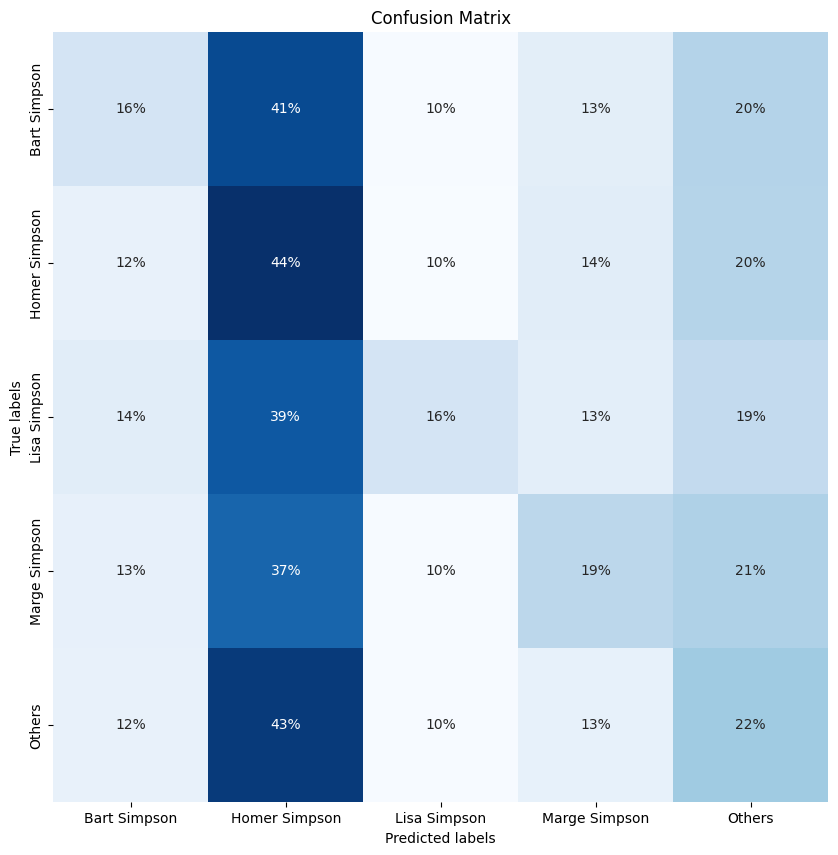

In [34]:
class_labels = np.unique(y)
conf_matrix=confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(10,10))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='.0%', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Método Frankenstein

## Tratamiento previo

In [28]:
df_frank = result_df.drop(['character_id', 'raw_character_text'], axis=1)
df_frank.sample()

,text_char_simplified,location_id,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,...,embedding_90,embedding_91,embedding_92,embedding_93,embedding_94,embedding_95,embedding_96,embedding_97,embedding_98,embedding_99
18255,Homer Simpson,5.0,6.019449e-07,0.000908,0.000623,-0.00025,0.001426,0.000691,0.000237,-0.000998,...,0.000185,-0.00038,-0.00022,0.001222,0.00015,-0.000127,0.000646,0.000367,-0.001298,-0.00059


In [29]:
def is_class(df, column, text):
    df[f'is_{text}'] = df[f'{column}'] == text
    return df[f'is_{text}']

In [30]:
list_classes = list(df_frank['text_char_simplified'].unique())
list_classes

for char in list_classes:
    is_class(df_frank, 'text_char_simplified', str(char))

In [31]:
df_frank.sample()

,text_char_simplified,location_id,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,...,embedding_95,embedding_96,embedding_97,embedding_98,embedding_99,is_Lisa Simpson,is_Bart Simpson,is_Others,is_Homer Simpson,is_Marge Simpson
43877,Lisa Simpson,270.0,-0.000504,-0.000332,-0.001626,0.001278,-0.001596,0.000442,0.000685,-0.001722,...,-0.001364,-0.002397,-0.002801,-0.000163,-0.002827,True,False,False,False,False


In [32]:
for char in list_classes:
    print(df_frank[f'is_{char}'].value_counts(), '\n')

is_Lisa Simpson
False    52612
True      7676
Name: count, dtype: int64 

is_Bart Simpson
False    51375
True      8913
Name: count, dtype: int64 

is_Others
False    46403
True     13885
Name: count, dtype: int64 

is_Homer Simpson
False    40338
True     19950
Name: count, dtype: int64 

is_Marge Simpson
False    50424
True      9864
Name: count, dtype: int64 



## Entrenamiento

In [90]:
X = df_frank.drop(['is_Lisa Simpson', 'is_Bart Simpson', 'is_Homer Simpson', 'is_Marge Simpson', 'is_Others', 'text_char_simplified'], axis=1)
y = df_frank[['is_Lisa Simpson', 'is_Bart Simpson', 'is_Homer Simpson', 'is_Marge Simpson', 'is_Others', 'text_char_simplified']]

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1989, stratify=y)

# Escalar características para normalizarlas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Accuracy score for is_Lisa Simpson: 0.5603748548681373 in Logistic Regression
Accuracy score for is_Bart Simpson: 0.563940952065019 in Logistic Regression
Accuracy score for is_Homer Simpson: 0.532924199701443 in Logistic Regression
Accuracy score for is_Marge Simpson: 0.5749709736274673 in Logistic Regression
Accuracy score for is_Others: 0.5276165201525957 in Logistic Regression


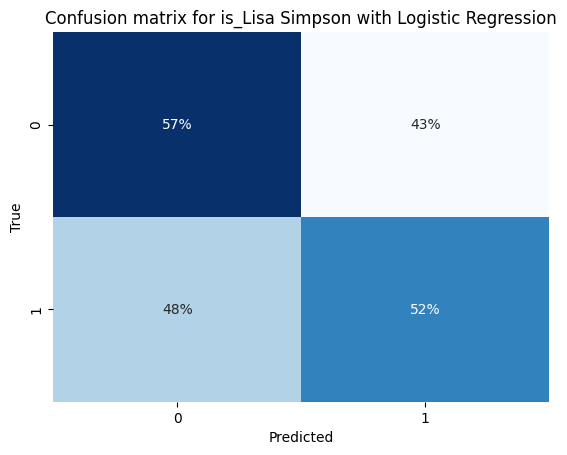

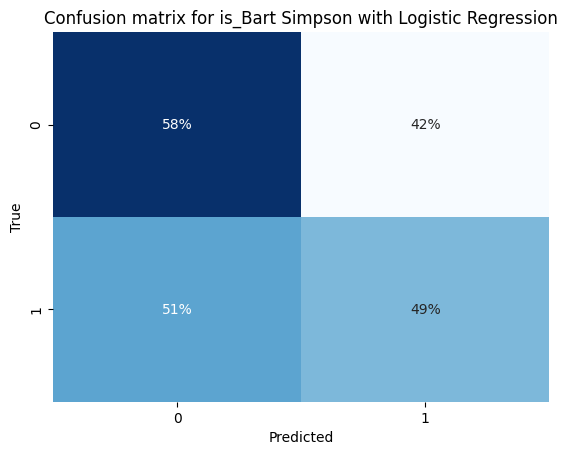

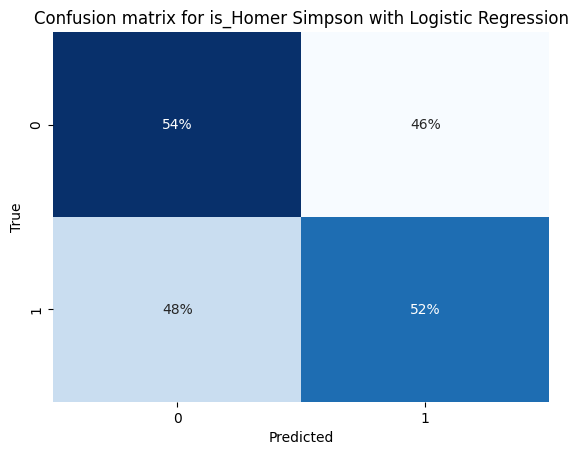

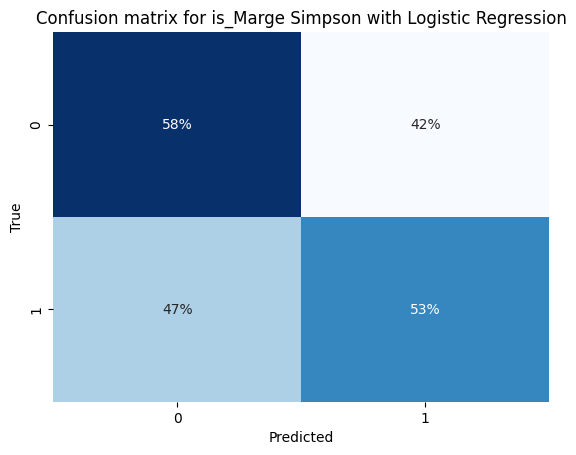

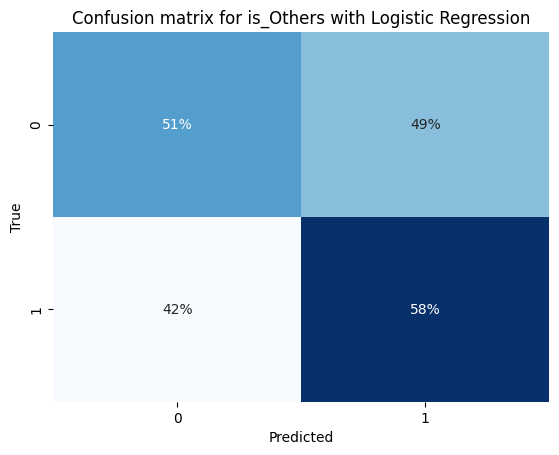

In [92]:
# Dictionary to store trained models
trained_models = {}

scores = []
confusion_matrices = []

for column in y.iloc[:, :-1].columns:
    # Train a model
    m = 'Logistic Regression'
    model = LogisticRegression(class_weight='balanced')
    model.fit(X_train_scaled, y_train[column])
    
    # Store the trained model
    trained_models[column] = model
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Evaluate the model
    score = accuracy_score(y_test[column], y_pred)
    
    # Store the score
    scores.append((column, score))
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test[column], y_pred, normalize='true')
    
    # Store the confusion matrix
    confusion_matrices.append((column, cm, m))

# Print the scores
for column, score in scores:
    print(f'Accuracy score for {column}: {score} in Logistic Regression')

# Plot the confusion matrices
for column, cm, m in confusion_matrices:
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='.0%', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion matrix for {column} with {m}')
    plt.show()


In [93]:
trained_models

{'is_Lisa Simpson': LogisticRegression(class_weight='balanced'),
 'is_Bart Simpson': LogisticRegression(class_weight='balanced'),
 'is_Homer Simpson': LogisticRegression(class_weight='balanced'),
 'is_Marge Simpson': LogisticRegression(class_weight='balanced'),
 'is_Others': LogisticRegression(class_weight='balanced')}

In [94]:
model_lisa = trained_models['is_Lisa Simpson']
model_bart = trained_models['is_Bart Simpson']
model_marge = trained_models['is_Marge Simpson']
model_homer = trained_models['is_Homer Simpson']
model_others = trained_models['is_Others']

## Predicciones

In [95]:
list_classes

['Lisa Simpson', 'Bart Simpson', 'Others', 'Homer Simpson', 'Marge Simpson']

In [96]:
y_pred_lisa = model_lisa.predict_proba(X_test)[:,1]*0.95
y_pred_df = pd.DataFrame(y_pred_lisa, columns=['Lisa Simpson'])

y_pred_df['Bart Simpson'] = model_bart.predict_proba(X_test)[:,1]
y_pred_df['Others'] = model_others.predict_proba(X_test)[:,1]*0.97
y_pred_df['Homer Simpson'] = model_homer.predict_proba(X_test)[:,1]
y_pred_df['Marge Simpson'] = model_marge.predict_proba(X_test)[:,1]

y_pred_df

,Lisa Simpson,Bart Simpson,Others,Homer Simpson,Marge Simpson
0,0.518799,4.676323e-01,0.515346,0.522499,3.916381e-01
1,0.828994,2.688622e-01,0.766316,0.709863,2.399869e-02
2,0.518749,4.677200e-01,0.515349,0.522513,3.915725e-01
3,0.950000,7.286190e-39,0.970000,1.000000,8.218948e-144
4,0.950000,1.018493e-11,0.970000,1.000000,5.947549e-42
...,...,...,...,...,...
12053,0.923136,1.409598e-01,0.891993,0.837802,1.188292e-03
12054,0.518777,4.676350e-01,0.515480,0.522489,3.915252e-01
12055,0.950000,3.473454e-37,0.970000,1.000000,1.630281e-137
12056,0.837723,2.606222e-01,0.775454,0.718074,2.051595e-02


In [97]:
y_pred_df = y_pred_df[['Others', 'Homer Simpson', 'Marge Simpson', 'Bart Simpson', 'Lisa Simpson']]
y_pred_df['Max_Probability_Class'] = y_pred_df.idxmax(axis=1)
y_pred_df

,Others,Homer Simpson,Marge Simpson,Bart Simpson,Lisa Simpson,Max_Probability_Class
0,0.515346,0.522499,3.916381e-01,4.676323e-01,0.518799,Homer Simpson
1,0.766316,0.709863,2.399869e-02,2.688622e-01,0.828994,Lisa Simpson
2,0.515349,0.522513,3.915725e-01,4.677200e-01,0.518749,Homer Simpson
3,0.970000,1.000000,8.218948e-144,7.286190e-39,0.950000,Homer Simpson
4,0.970000,1.000000,5.947549e-42,1.018493e-11,0.950000,Homer Simpson
...,...,...,...,...,...,...
12053,0.891993,0.837802,1.188292e-03,1.409598e-01,0.923136,Lisa Simpson
12054,0.515480,0.522489,3.915252e-01,4.676350e-01,0.518777,Homer Simpson
12055,0.970000,1.000000,1.630281e-137,3.473454e-37,0.950000,Homer Simpson
12056,0.775454,0.718074,2.051595e-02,2.606222e-01,0.837723,Lisa Simpson


In [98]:
y_pred_frank = y_pred_df['Max_Probability_Class']
y_test_frank = y_test['text_char_simplified']
accuracy_score(y_test_frank, y_pred_frank)

0.2872781555813568

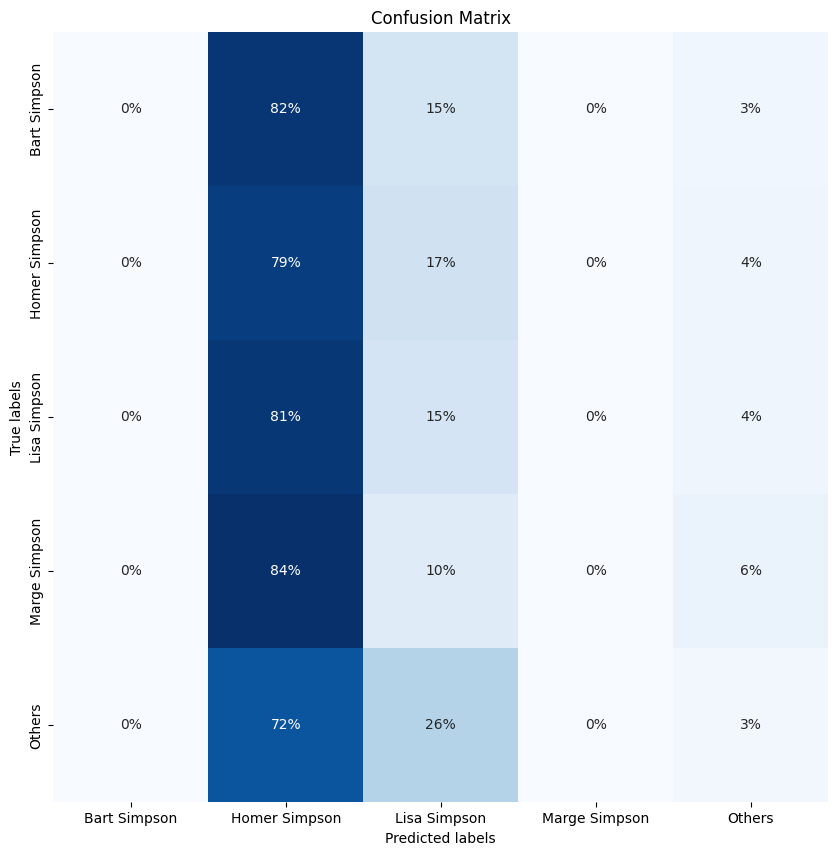

In [99]:
class_labels = np.unique(y_test_frank)

conf_matrix=confusion_matrix(y_test_frank, y_pred_frank, normalize='true')

plt.figure(figsize=(10,10))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='.0%', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Clasificación con reducción de componentes

In [54]:
# Dividir el DataFrame en características (X) y etiquetas (y)
X = result_df.drop(['character_id', 'raw_character_text', 'text_char_simplified'], axis=1) 
y = result_df['text_char_simplified']

## Optimizaciones

In [55]:
pipe_rfc = Pipeline([('pca', PCA(n_components=0.75)),('scaler', StandardScaler()), ('rfc', RandomForestClassifier(class_weight='balanced'))])
grid_params_rfc = {
    'rfc__n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 130, 150],
    'rfc__max_depth': [5]#[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}
gs_rfc = GridSearchCV(pipe_rfc, grid_params_rfc, cv = 5, verbose=1, scoring= 'accuracy',return_train_score=True)

In [56]:
gs_rfc.fit(X,y)

Fitting 5 folds for each of 13 candidates, totalling 65 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pca', PCA(n_components=0.75)),
                                       ('scaler', StandardScaler()),
                                       ('rfc',
                                        RandomForestClassifier(class_weight='balanced'))]),
             param_grid={'rfc__max_depth': [5],
                         'rfc__n_estimators': [10, 20, 30, 40, 50, 60, 70, 80,
                                               90, 100, 110, 130, 150]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [57]:
df_gs_rfc = pd.DataFrame(gs_rfc.cv_results_['params'])
df_gs_rfc['test_result'] = gs_rfc.cv_results_['mean_test_score']
df_gs_rfc['train_result'] = gs_rfc.cv_results_['mean_train_score']
df_gs_rfc.head(3)

,rfc__max_depth,rfc__n_estimators,test_result,train_result
0,5,10,0.281382,0.291381
1,5,20,0.281830,0.289104
2,5,30,0.282344,0.292853


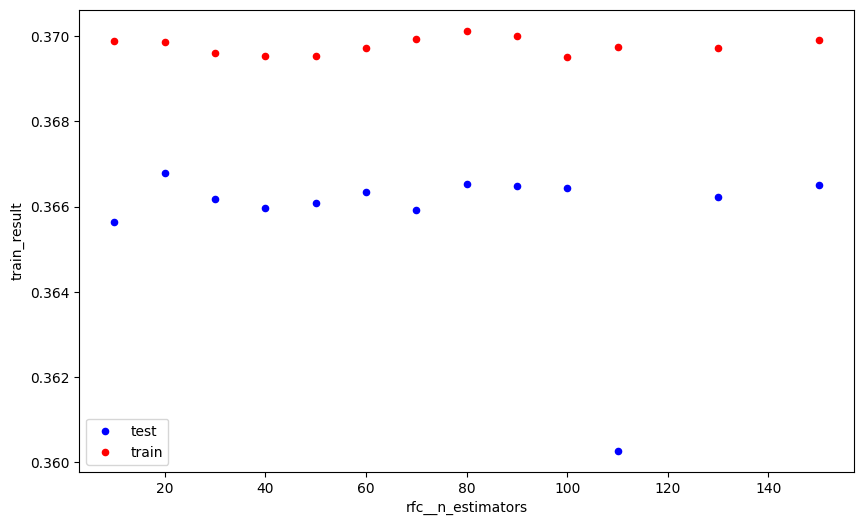

In [83]:
fig, ax = plt.subplots(figsize=(10,6))
df_gs_rfc.plot.scatter('rfc__n_estimators', 'test_result', label='test', ax=ax, color='blue')
df_gs_rfc.plot.scatter('rfc__n_estimators', 'train_result', label='train', ax=ax, color='red')
plt.legend()

De max_depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] para n_estimators = 30 el mejor ha sido: 5

De n_estimators = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 130, 150] para max_depth = 5 el mejor ha sido: 20

## Métricas

In [76]:
## Aplicando PCA
pca = PCA(n_components=0.8)  
X_pca = pca.fit_transform(X)

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=1989)

# Escalar características para normalizarlas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear y entrenar el model_rfco de regresión logística
model_rfc = RandomForestClassifier(n_estimators=20, max_depth=5)
model_rfc.fit(X_train_scaled, y_train)

# Predecir las etiquetas para el conjunto de prueba
y_pred = model_rfc.predict(X_test_scaled)

# Calcular la precisión del model_rfco
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Mostrar el reporte de clasificación
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.36880079615193234

Classification Report:
               precision    recall  f1-score   support

 Bart Simpson       0.28      0.02      0.04      1808
Homer Simpson       0.35      0.89      0.51      4029
 Lisa Simpson       0.49      0.02      0.05      1504
Marge Simpson       0.00      0.00      0.00      2012
       Others       0.46      0.29      0.36      2705

     accuracy                           0.37     12058
    macro avg       0.32      0.25      0.19     12058
 weighted avg       0.32      0.37      0.26     12058



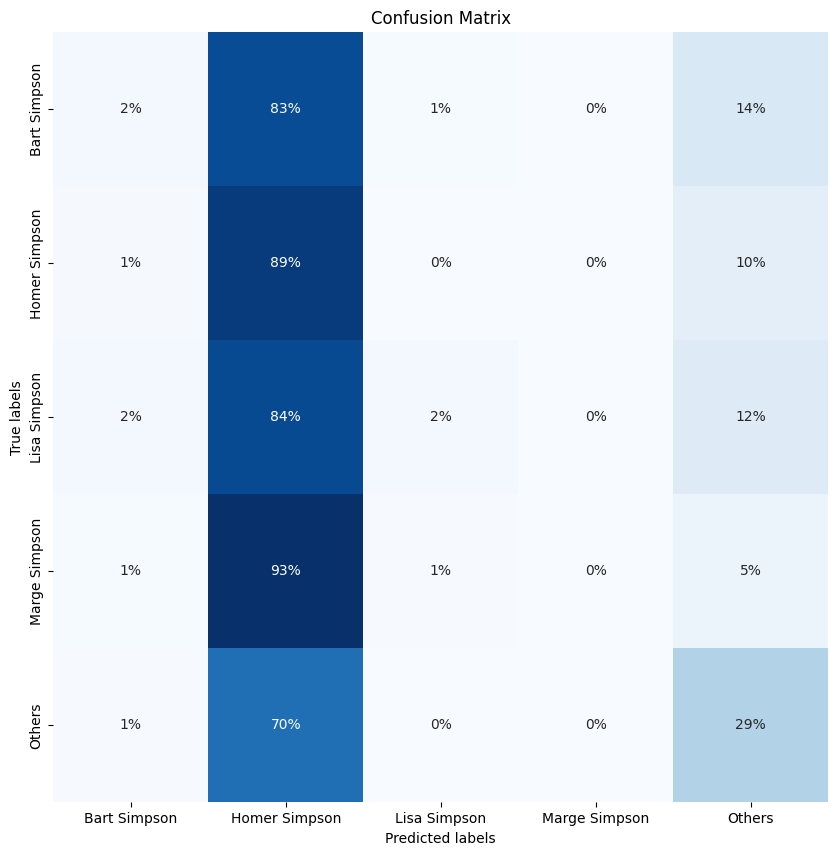

In [77]:
class_labels = np.unique(y_test)
conf_matrix=confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(10,10))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='.0%', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Exportando Modelos usados:

## PCA

In [78]:
Xpca = pca.fit_transform(X)

In [79]:
with open('Modelos/Clasificación/pca.pkl', 'wb') as file:
    pickle.dump(pca, file)

In [80]:
joblib.dump(pca, 'Modelos/Clasificación/pca.bin', compress=True)

['Modelos/Clasificación/pca.bin']

## Scaler

In [81]:
X_scaled = scaler.fit_transform(Xpca)

In [82]:
X.to_csv('The Saimpsons Archive/in_use/data_classification_training_scaler.csv', index=False)

In [83]:
with open('Modelos/Clasificación/standard_scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [84]:
joblib.dump(scaler, 'Modelos/Clasificación/standard_scaler.bin', compress=True)

['Modelos/Clasificación/standard_scaler.bin']

## Random Forest

In [85]:
model_rfc.fit(X_scaled, y)

RandomForestClassifier(max_depth=5, n_estimators=20)

In [86]:
with open('Modelos/Clasificación/random_forest.pkl', 'wb') as file:
    pickle.dump(model_rfc, file)

In [87]:
joblib.dump(model_rfc, 'Modelos/Clasificación/random_forest.bin', compress=True)

['Modelos/Clasificación/random_forest.bin']

## Diferencia character_id vs raw_character

In [88]:
df.sample()

,episode_id,character_id,raw_character_text,location_id,spoken_words,spoken_words_count,text_char_simplified
25548,268,8.0,Bart Simpson,27.0,But the black man said...,5,Bart Simpson


In [89]:
df[df['character_id']==2]['raw_character_text'].unique()

array(['Homer Simpson', 'Young Homer', 'Teenage Homer', "Homer's Brain",
       "Homer's Thoughts"], dtype=object)